In [242]:
### Data Preprocessing Script for Diabetes Dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline


df = pd.read_csv("../data/diabetes2.csv")

# Columns where zero is INVALID and should be treated as missing
cols_with_invalid_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zeros with NaN
for col in cols_with_invalid_zeros:
    df[col] = df[col].replace(0, np.nan)

# Split features/target
df_features  = df.drop("Outcome", axis=1)
df_target = df["Outcome"]


pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

# Apply pipeline to feature data
processed_features = pipeline.fit_transform(df_features)

# Build final labeled and unlabeled dataframe
df_processed = pd.DataFrame(processed_features, columns=df_features.columns)
df_labeled = df_processed.copy()
df_labeled["Outcome"] = df_target.values


### KMeans and Analysis

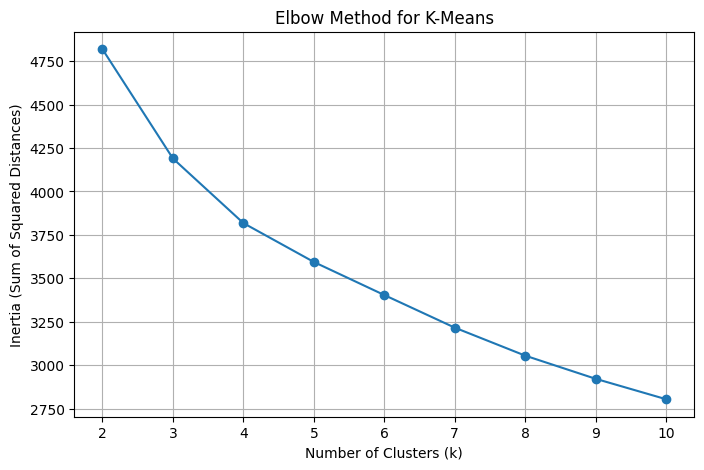

In [243]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Feature matrix for clustering (exclude labels or old cluster columns)
X = df_processed.drop(columns=["Outcome", "hier_cluster", "kmeans_cluster"], errors="ignore").values

# Elbow Method (k = 2 to 10)
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid(True)
plt.show()

In [244]:
best_k = 3 # try 4, then 5, then 6

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to your processed df
df_labeled["kmeans_cluster"] = kmeans_cluster_labels



In [245]:
#Evaluating the best k value with Silhouette Score and Davies-Bouldin Index


sil_score = silhouette_score(X, kmeans_cluster_labels)
db_index = davies_bouldin_score(X, kmeans_cluster_labels)

print(f"K-Means (k={best_k}) Silhouette Score: {sil_score:.3f}")
print(f"K-Means (k={best_k}) Davies-Bouldin Index: {db_index:.3f}")

K-Means (k=3) Silhouette Score: 0.207
K-Means (k=3) Davies-Bouldin Index: 1.780


KMeans Cluster Eval

K = 3
sil_score = 0.207
db_index = 1.782

K = 4
sil_score = 0.174
db_index = 1.681

K = 5
sil_score = 0.150
db_index = 1.858

K = 6
sil_score = 0.156
db_index = 1.792


The goal is to maximize sil score and minimize db index, hence K = 3 is the best

sil score  measures how similar a point is to its own cluster compared to other clusters, intracluster cohesion. db index measures how similar (how close and overlapping) clusters are to each other.


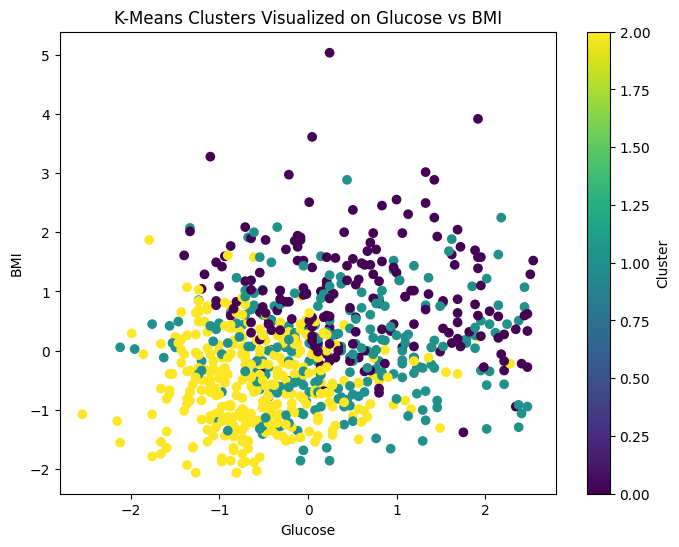

In [246]:
import matplotlib.pyplot as plt

# Pick two features to plot (choose any two)
### Pregnancies,	Glucose,	BloodPressure,	SkinThickness,	Insulin, BMI	DiabetesPedigreeFunction, Age 

def kmeans_feature_plot(dataset,feature_x, feature_y):
    plt.figure(figsize=(8,6))
    plt.scatter(
        dataset[feature_x],
        dataset[feature_y],
        c=kmeans_cluster_labels,
        cmap='viridis'
    )

    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"K-Means Clusters Visualized on {feature_x} vs {feature_y}")
    plt.colorbar(label="Cluster")
    plt.show()

kmeans_feature_plot(df_processed,"Glucose", "BMI")

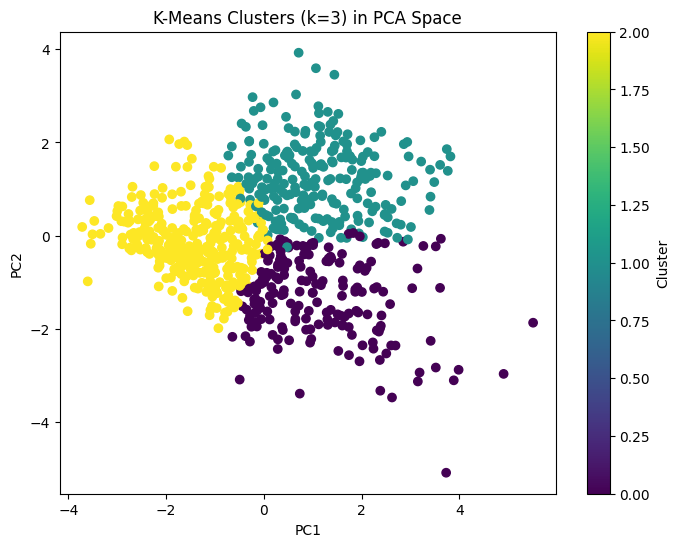

In [247]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_cluster_labels, cmap='viridis')
plt.title(f"K-Means Clusters (k={best_k}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


### Hierarchical clustering and Analysis

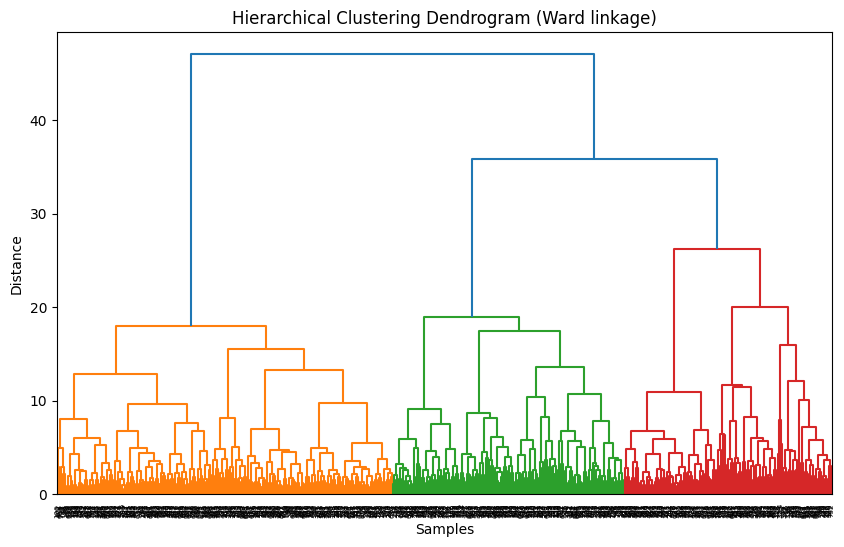

In [248]:
### Hierarchical Clustering on Diabetes Dataset

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 0. Build X from features ONLY (ignore Outcome / previous cluster labels)
X = df_processed.drop(columns=["Outcome", "hier_cluster", "kmeans_cluster"], errors="ignore").values

# -----------------------------
# 1. Dendrogram (Ward linkage)
# -----------------------------
linked = linkage(X, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# -------------------------------------------
# 2. Fit Agglomerative Clustering 
# -------------------------------------------
n_clusters = 3

agg = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage="ward"
)
agg_labels = agg.fit_predict(X)

# Add labels to processed DataFrame (for analysis only)
df_labeled["hier_cluster"] = agg_labels

In [249]:
# --------------------------------
# 3. Evaluation Metrics
# --------------------------------
sil_score_hier = silhouette_score(X, agg_labels)
db_index_hier = davies_bouldin_score(X, agg_labels)

print(f"Hierarchical (k={n_clusters}) Silhouette Score: {sil_score_hier:.3f}")
print(f"Hierarchical (k={n_clusters}) Davies-Bouldin Index: {db_index_hier:.3f}")

Hierarchical (k=3) Silhouette Score: 0.182
Hierarchical (k=3) Davies-Bouldin Index: 1.935


Agglomerative Clustering Eval

K = 3
sil_score = 0.177
db_index = 1.999

K = 4
sil_score = 0.126
db_index = 1.84

K = 5
sil_score = 0.134
db_index = 1.712

K = 6
sil_score = 0.115
db_index = 2.040

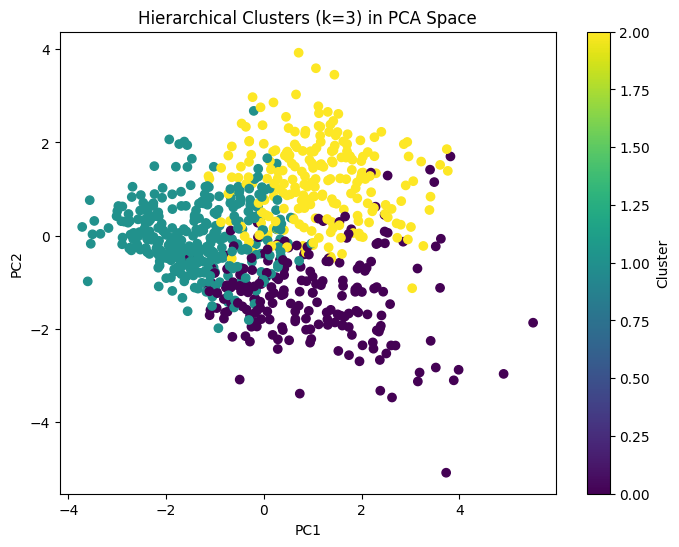

In [250]:
# --------------------------------
# 4. PCA Visualization (2D)
# --------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap="viridis")
plt.title(f"Hierarchical Clusters (k={n_clusters}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

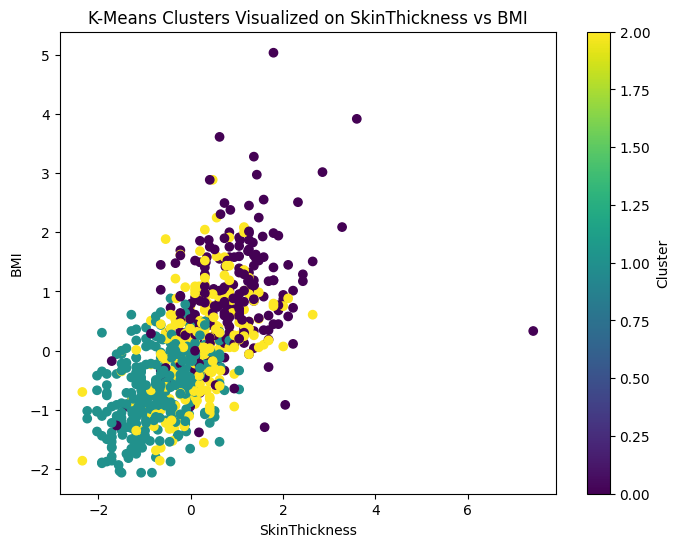

In [251]:
# Pick two features to plot (choose any two)
### Pregnancies,	Glucose,	BloodPressure,	SkinThickness,	Insulin, BMI	DiabetesPedigreeFunction, Age 

def hierarchial_feature_plot(dataset,feature_x, feature_y):
    plt.figure(figsize=(8,6))
    plt.scatter(
        dataset[feature_x],
        dataset[feature_y],
        c=agg_labels,
        cmap='viridis'
    )

    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"K-Means Clusters Visualized on {feature_x} vs {feature_y}")
    plt.colorbar(label="Cluster")
    plt.show()

hierarchial_feature_plot(df_processed,"SkinThickness", "BMI")

### DBScan  & Analysis 

In [252]:
### DBSCAN Clustering on Diabetes Dataset

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Use scaled features
X = X = df_processed.drop(columns=["Outcome", "hier_cluster", "kmeans_cluster","dbscan_cluster"], errors="ignore").values

# ----------------------------------------
# 1. Parameter Tuning (eps & min_samples)
# ----------------------------------------

eps_values = [0.8, 1.0, 1.2, 1.5, 2.0, 3.0]
min_samples_values = [3, 4, 5, 6, 8, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        # Must have more than 1 cluster & some non-outliers to compute silhouette
        if len(set(labels)) > 1 and np.sum(labels != -1) > 0:
            sil = silhouette_score(X, labels)
            dbi = davies_bouldin_score(X, labels)
        else:
            sil = None
            dbi = None

        results.append((eps, ms, len(set(labels)), np.sum(labels == -1), sil, dbi))

# Display tuning results
for r in results:
    print(f"eps={r[0]}, min_samples={r[1]}, clusters={r[2]}, outliers={r[3]}, " f"silhouette={r[4]}, dbi={r[5]}")

eps=0.8, min_samples=3, clusters=15, outliers=655, silhouette=-0.28444660746831224, dbi=1.88686063446942
eps=0.8, min_samples=4, clusters=13, outliers=694, silhouette=-0.30789240309942495, dbi=1.8097428680080887
eps=0.8, min_samples=5, clusters=6, outliers=730, silhouette=-0.2919435651144546, dbi=1.9610318918774652
eps=0.8, min_samples=6, clusters=3, outliers=748, silhouette=-0.2828270281890692, dbi=2.590199632879344
eps=0.8, min_samples=8, clusters=2, outliers=757, silhouette=-0.13992699015326557, dbi=1.545052842420886
eps=0.8, min_samples=10, clusters=1, outliers=768, silhouette=None, dbi=None
eps=1.0, min_samples=3, clusters=15, outliers=459, silhouette=-0.31038484115582565, dbi=1.8271404179330846
eps=1.0, min_samples=4, clusters=7, outliers=521, silhouette=-0.1851200148298248, dbi=1.7338908776359414
eps=1.0, min_samples=5, clusters=5, outliers=545, silhouette=-0.14974121520175354, dbi=1.8825697208118968
eps=1.0, min_samples=6, clusters=3, outliers=585, silhouette=-0.115138107258763

In [253]:
best_eps = 3.0
best_min_samples = 5

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
db_labels = dbscan.fit_predict(X)

df_labeled["dbscan_cluster"] = db_labels

unique_clusters = set(db_labels)
print("DBSCAN clusters found:", unique_clusters)
print("Number of noise points:", np.sum(db_labels == -1))

DBSCAN clusters found: {np.int64(0), np.int64(-1)}
Number of noise points: 5


In [254]:
if len(unique_clusters) > 1 and np.sum(db_labels != -1) > 0:
    sil_score_db = silhouette_score(X, db_labels)
    db_index_dbscan = davies_bouldin_score(X, db_labels)
else:
    sil_score_db = None
    db_index_dbscan = None

print("DBSCAN Silhouette Score:", sil_score_db)
print("DBSCAN Davies-Bouldin Index:", db_index_dbscan)

DBSCAN Silhouette Score: 0.5490533187267362
DBSCAN Davies-Bouldin Index: 1.4650554856368463


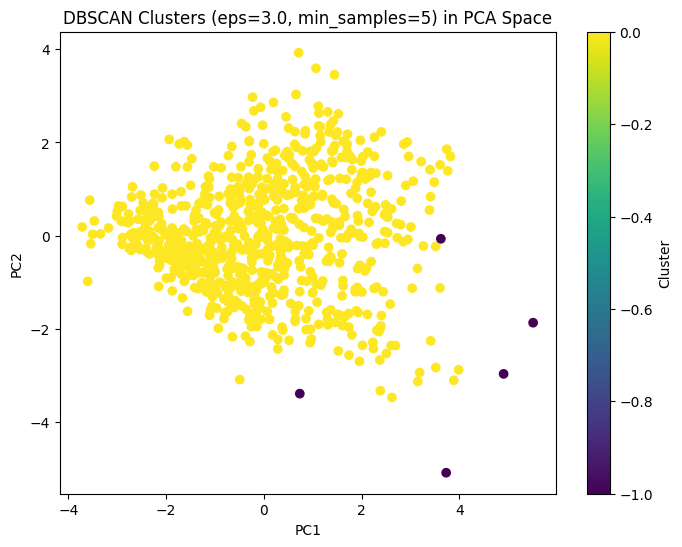

In [255]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap="viridis")
plt.title(f"DBSCAN Clusters (eps={best_eps}, min_samples={best_min_samples}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [257]:



pd.crosstab(df_labeled["kmeans_cluster"], df_labeled["Outcome"])




Outcome,0,1
kmeans_cluster,,
0,90,102
1,114,125
2,296,41


In [ ]:
pd.crosstab(df_labeled["hier_cluster"], df_labeled["Outcome"])

Outcome,0,1
hier_cluster,,
0,108,98
1,276,57
2,116,113


In [ ]:
pd.crosstab(df_labeled["dbscan_cluster"], df_labeled["Outcome"])

Outcome,0,1
dbscan_cluster,,
-1,1,4
0,499,264


In [258]:
def cluster_purity(cluster_labels, true_labels):
    df_temp = pd.DataFrame({"cluster": cluster_labels, "true": true_labels})
    purity_sum = 0

    for c in df_temp["cluster"].unique():
        members = df_temp[df_temp["cluster"] == c]
        purity_sum += members["true"].value_counts().max()
    
    return purity_sum / len(df_temp)

print("KMeans Purity:", cluster_purity(df_labeled["kmeans_cluster"], df_labeled["Outcome"]))
print("Hierarchical Purity:", cluster_purity(df_labeled["hier_cluster"], df_labeled["Outcome"]))
print("DBSCAN Purity:", cluster_purity(df_labeled["dbscan_cluster"], df_labeled["Outcome"]))

KMeans Purity: 0.6809895833333334
Hierarchical Purity: 0.6510416666666666
DBSCAN Purity: 0.6549479166666666


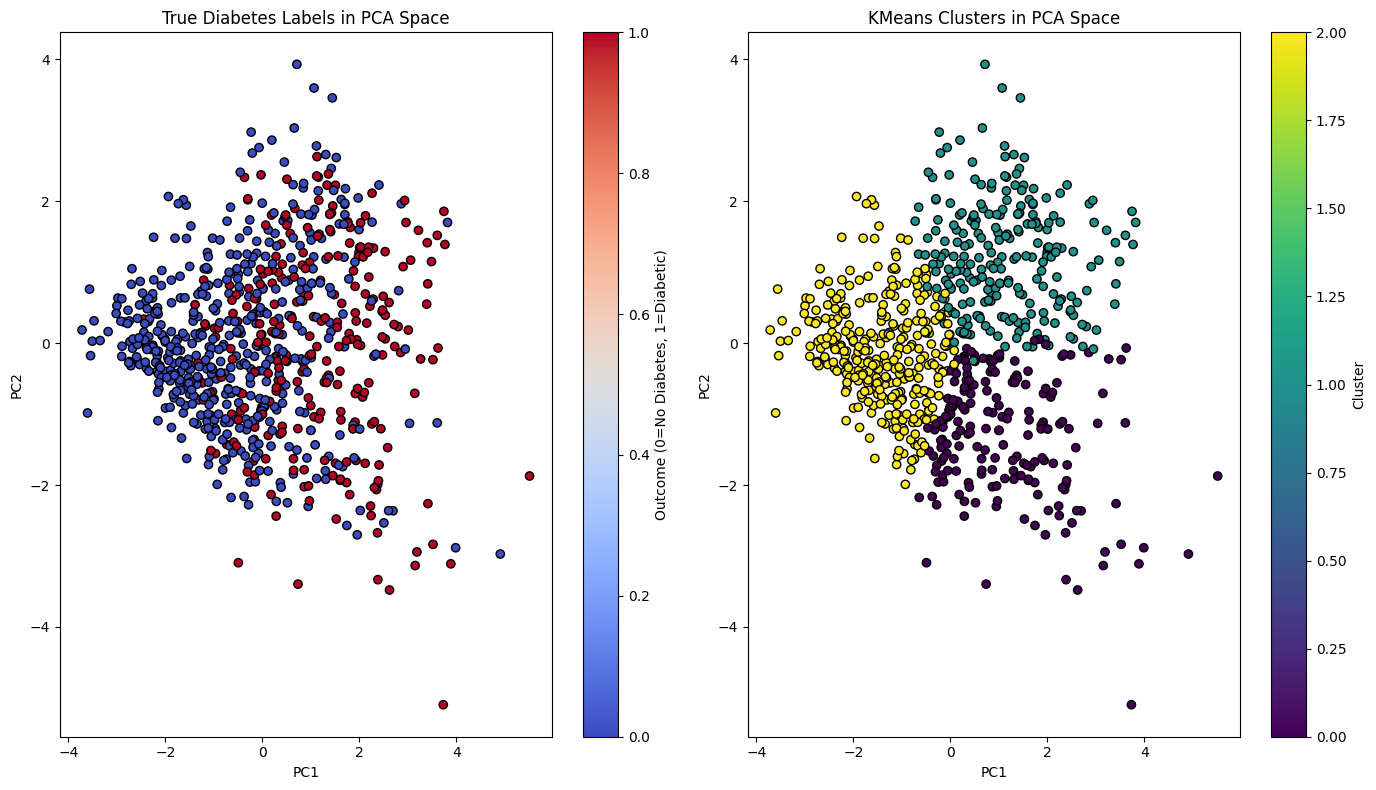

In [261]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use processed (scaled, feature-only) data for PCA
X = df_processed.values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(14, 8))

# -----------------------------
# 1. True labels in PCA space
# -----------------------------
plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df_labeled["Outcome"],      # <-- true labels from df_labeled
    cmap="coolwarm",
    edgecolor="k"
)
plt.title("True Diabetes Labels in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Outcome (0=No Diabetes, 1=Diabetic)")

# -----------------------------
# 2. KMeans clusters in PCA space
# -----------------------------
plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df_labeled["kmeans_cluster"],   # <-- cluster labels from df_labeled
    cmap="viridis",
    edgecolor="k"
)
plt.title("KMeans Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")

plt.tight_layout()
plt.show()

/var/folders/l5/1vzggpq925j2hxl4nw9341xc0000gp/T/ipykernel_81081/217862410.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


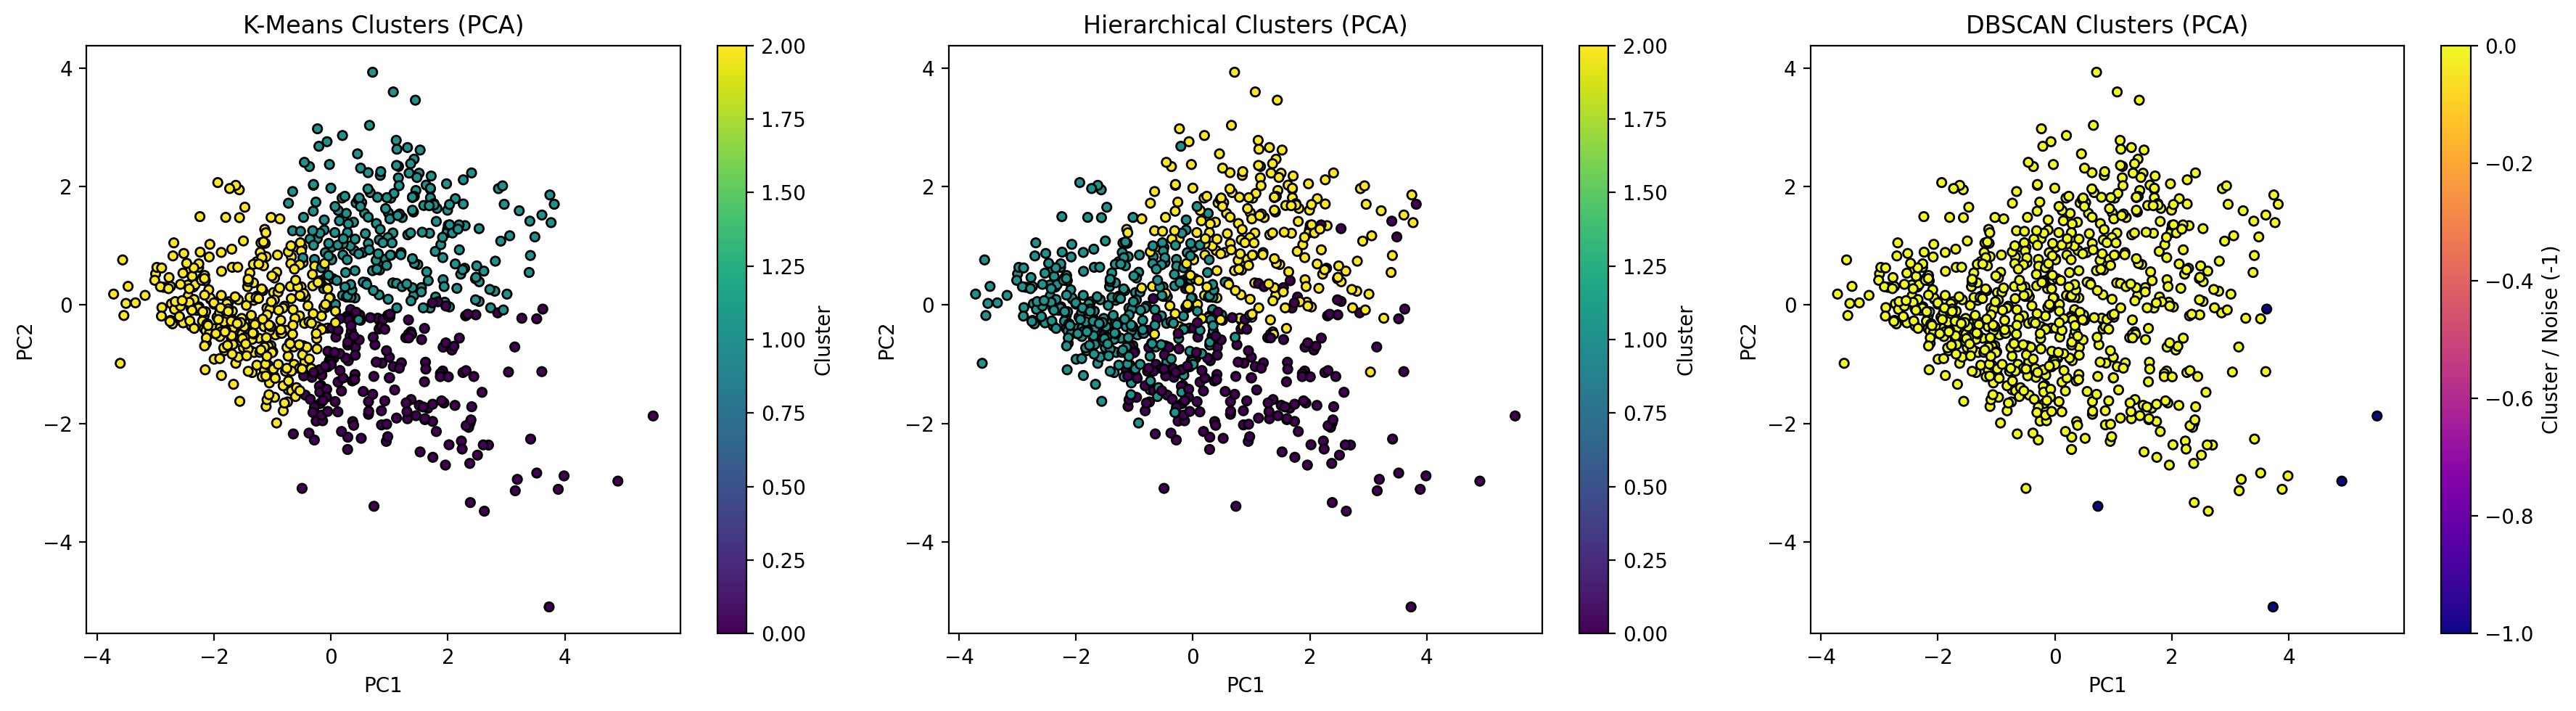

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA





# Use processed (scaled) feature-only data
X = df_processed.values  

# Fit PCA once on the scaled features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cluster labels pulled from df_labeled (correct location)
labels_kmeans = df_labeled["kmeans_cluster"]
labels_hier   = df_labeled["hier_cluster"]
labels_dbscan = df_labeled["dbscan_cluster"]

# Plot setup
plt.figure(figsize=(18, 5))

# -------------------------
# 1. K-Means
# -------------------------
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis', s=20, edgecolor='k')
plt.title("K-Means Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")

# -------------------------
# 2. Hierarchical Clustering
# -------------------------
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap='viridis', s=20, edgecolor='k')
plt.title("Hierarchical Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")

# -------------------------
# 3. DBSCAN (noise = -1)
# -------------------------
plt.subplot(1, 3, 3)
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=labels_dbscan, 
    cmap='plasma',    
    s=20,
    edgecolor='k'
)
plt.title("DBSCAN Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster / Noise (-1)")

plt.tight_layout()
plt.show()